In [18]:
import pandas as pd
import math
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

pos_type_names = ['exp_id','rep','weather','start_point','end_point','result','initial_distance','final_distance',
                  'final_time','time_out','num_ped','num_veh']
all_details_names=['exp_id','rep','weather','collision_gen','collision_ped','collision_car','lane_intersect',
                   'sidewalk_intersect','pos_x','pos_y','num_ped','num_veh']

class FI_Data(object):
    def __init__(self,town,f_i,fname_pose_type,fname_details):
        self.town=town
        self.f_i=f_i
        self.exp_by_pos_type = pd.read_csv(fname_pose_type,sep=',',names=pos_type_names,skiprows=1)
        self.exp_all_details = pd.read_csv(fname_details,sep=',',names=all_details_names,skiprows=1)
        
    def get_fi_name(self):
        return self.f_i
        
    def get_town_name(self):
        return self.town
    
    def get_exp_by_pos_type(self):
        return self.exp_by_pos_type
    
    def get_exp_all_details(self):
        return self.exp_all_details

In [38]:
DATASET = [
    FI_Data('Town1','NoInject','raw_csv/test_uiuc_fi_2018_Town01_PassThrough/w1.3.6.8.csv',
           'raw_csv/test_uiuc_fi_2018_Town01_PassThrough/details_w1.3.6.8.csv'),
    FI_Data('Town2','NoInject','raw_csv/test_uiuc_fi_2018_Town02_PassThrough/w1.3.6.8.csv',
           'raw_csv/test_uiuc_fi_2018_Town02_PassThrough/details_w1.3.6.8.csv'),
    FI_Data('Town1','Gaussian','raw_csv/test_uiuc_fi_2018_Town01_Gaussian/w1.3.6.8.csv',
           'raw_csv/test_uiuc_fi_2018_Town01_Gaussian/details_w1.3.6.8.csv'),
    FI_Data('Town2','Gaussian','raw_csv/test_uiuc_fi_2018_Town02_Gaussian/w1.3.6.8.csv',
           'raw_csv/test_uiuc_fi_2018_Town02_Gaussian/details_w1.3.6.8.csv'),
    FI_Data('Town1','S&P','raw_csv/test_uiuc_fi_2018_Town01_SaltAndPepper/w1.3.6.8.csv',
           'raw_csv/test_uiuc_fi_2018_Town01_SaltAndPepper/details_w1.3.6.8.csv'),
    FI_Data('Town2','S&P','raw_csv/test_uiuc_fi_2018_Town02_SaltAndPepper/w1.3.6.8.csv',
           'raw_csv/test_uiuc_fi_2018_Town02_SaltAndPepper/details_w1.3.6.8.csv'),
    FI_Data('Town1','SolidOcc','raw_csv/test_uiuc_fi_2018_Town01_SolidOcclusion/w1.3.6.8.csv',
           'raw_csv/test_uiuc_fi_2018_Town01_SolidOcclusion/details_w1.3.6.8.csv'),
    FI_Data('Town2','SolidOcc','raw_csv/test_uiuc_fi_2018_Town02_SolidOcclusion/w1.3.6.8.csv',
           'raw_csv/test_uiuc_fi_2018_Town02_SolidOcclusion/details_w1.3.6.8.csv'),
    FI_Data('Town1','TranspOcc','raw_csv/test_uiuc_fi_2018_Town01_TransparentOcclusion/w1.3.6.8.csv',
           'raw_csv/test_uiuc_fi_2018_Town01_TransparentOcclusion/details_w1.3.6.8.csv'),
    FI_Data('Town2','TranspOcc','raw_csv/test_uiuc_fi_2018_Town02_TransparentOcclusion/w1.3.6.8.csv',
           'raw_csv/test_uiuc_fi_2018_Town02_TransparentOcclusion/details_w1.3.6.8.csv'),
    FI_Data('Town1','WaterDrop','raw_csv/test_uiuc_fi_2018_Town01_WaterDrop/w1.3.6.8.csv',
           'raw_csv/test_uiuc_fi_2018_Town01_WaterDrop/details_w1.3.6.8.csv'),
    FI_Data('Town2','WaterDrop','raw_csv/test_uiuc_fi_2018_Town02_WaterDrop/w1.3.6.8.csv',
           'raw_csv/test_uiuc_fi_2018_Town02_WaterDrop/details_w1.3.6.8.csv'),
    
]

In [39]:
#Function definitions to extract information from raw log files
#Credit to CARLA
sldist = lambda c1, c2: math.sqrt((c2[0] - c1[0])**2 + (c2[1] - c1[1])**2)

def get_distance_traveled(selected_matrix, header):

    prev_x = selected_matrix[0, header.index('pos_x')]
    prev_y = selected_matrix[0, header.index('pos_y')]

    i = 1
    acummulated_distance = 0
    while i < selected_matrix.shape[0]:

        x = selected_matrix[i, header.index('pos_x')]
        y = selected_matrix[i, header.index('pos_y')]
        # Here we defined a maximun distance in a tick, this case 8 meters or 288km/h
        if sldist((x, y), (prev_x, prev_y)) < 800:
            acummulated_distance += sldist((x, y), (prev_x, prev_y))


        prev_x = x
        prev_y = y

        i += 1

    return float(acummulated_distance)/float(100*1000)

def get_colisions(selected_matrix, header):

    count_gen = 0
    count_ped = 0
    count_car = 0
    i = 1

    while i < selected_matrix.shape[0]:
        if (selected_matrix[i, header.index('collision_gen')]
                - selected_matrix[(i-10), header.index('collision_gen')]) > 40000:
            count_gen += 1
            i += 20
        i += 1

    i = 1
    while i < selected_matrix.shape[0]:
        if (selected_matrix[i, header.index('collision_car')]
                - selected_matrix[(i-10), header.index('collision_car')]) > 40000:
            count_car += 1
            i += 30
        i += 1

    i = 1
    while i < selected_matrix.shape[0]:
        if (selected_matrix[i, header.index('collision_ped')]
                - selected_matrix[i-5, header.index('collision_ped')]) > 30000:
            count_ped += 1
            i += 100
        i += 1

    return count_gen, count_car, count_ped

def get_out_of_road_lane(selected_matrix, header):

    count_road = 0
    count_lane = 0

    i = 0

    while i < selected_matrix.shape[0]:
        # print selected_matrix[i,6]
        if (selected_matrix[i, header.index('sidewalk_intersect')]
                - selected_matrix[(i-10), header.index('sidewalk_intersect')]) > 0.3:
            count_road += 1
            i += 20
        if i >= selected_matrix.shape[0]:
            break

        if (selected_matrix[i, header.index('lane_intersect')]
                - selected_matrix[(i-10), header.index('lane_intersect')]) > 0.4:
            count_lane += 1
            i += 20

        i += 1

    return count_lane, count_road


In [45]:
FI_col_gen={}
FI_col_hum={}
FI_col_car={}
FI_lane_out={}
FI_swalk_out={}

infract_data = pd.DataFrame(columns=['FI', 'Town','Distance','col_gen', 'col_car', 'col_hum',
                                     'col_total','lane_out', 'swalk_out'])


for FI in DATASET:

    df = FI.get_exp_all_details()
    
    unique_ids=np.unique(df["exp_id"].values)
    
    for exp_id in unique_ids:
        exp_mat = df.loc[df["exp_id"]==exp_id].values

        km=get_distance_traveled(exp_mat,all_details_names)

        c_gen,c_car,c_ped = get_colisions(exp_mat,all_details_names)
        lane_out,swalk_out = get_out_of_road_lane(exp_mat,all_details_names)
        
        infract_data = infract_data.append({
            'FI':FI.get_fi_name(),
            'Town':FI.get_town_name(),
            'Distance':km,
            'col_gen':c_gen/km,
            'col_car':c_car/km,
            'col_hum':c_ped/km,
            'col_total':(c_gen+c_car+c_ped)/km,
            'lane_out':lane_out/km,
            'swalk_out':swalk_out/km},ignore_index=True)

    

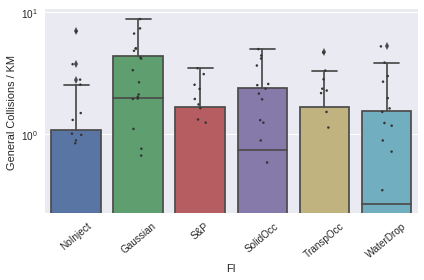

In [55]:
#(GeneralCollisions)/km by FI

ax = sns.boxplot(x='FI', y='col_gen', data=infract_data)
sns.stripplot(x='FI', y='col_gen', data=infract_data, color='0.2', jitter=True, marker=".")
ax.set_yscale('log')
ax.set_ylabel('General Collisions / KM')
plt.xticks(rotation=40)
plt.tight_layout()
plt.show()

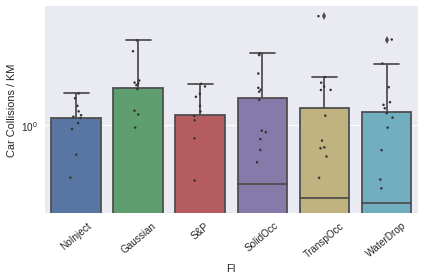

In [54]:
#(CarCollisions)/km by FI
ax = sns.boxplot(x='FI', y='col_car', data=infract_data)
sns.stripplot(x='FI', y='col_car', data=infract_data, color='0.2', jitter=True, marker=".")
ax.set_yscale('log')
ax.set_ylabel('Car Collisions / KM')
plt.xticks(rotation=40)
plt.tight_layout()
plt.show()


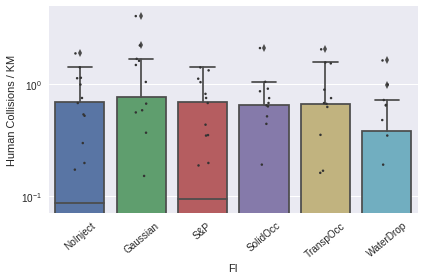

In [53]:
#(HumanCollisions)/km by FI
ax = sns.boxplot(x='FI', y='col_hum', data=infract_data)
sns.stripplot(x='FI', y='col_hum', data=infract_data, color='0.2', jitter=True, marker=".")
ax.set_yscale('log')
ax.set_ylabel('Human Collisions / KM')
plt.xticks(rotation=40)
plt.tight_layout()
plt.show()

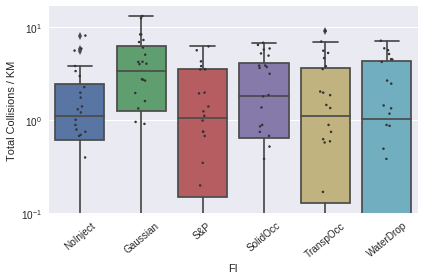

In [52]:
#(TotalCollisions)/km by FI
ax = sns.boxplot(x='FI', y='col_total', data=infract_data)
sns.stripplot(x='FI', y='col_total', data=infract_data, color='0.2', jitter=True, marker=".")
ax.set_yscale('log')
ax.set_ylabel('Total Collisions / KM')
plt.xticks(rotation=40)
plt.tight_layout()
plt.show()

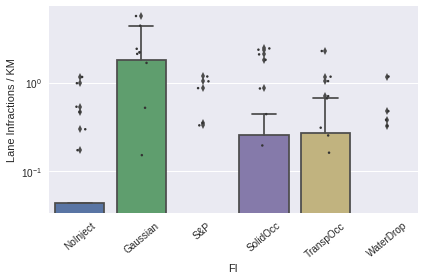

In [51]:
#(LaneInfractions)/km by FI
ax = sns.boxplot(x='FI', y='lane_out', data=infract_data)
sns.stripplot(x='FI', y='lane_out', data=infract_data, color='0.2', jitter=True, marker=".")
ax.set_yscale('log')
ax.set_ylabel('Lane Infractions / KM')
plt.xticks(rotation=40)
plt.tight_layout()
plt.show()

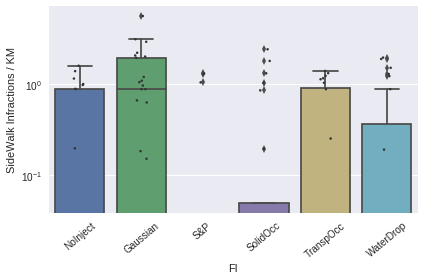

In [56]:
#(SideWalkInfractions)/km by FI
ax = sns.boxplot(x='FI', y='swalk_out', data=infract_data)
sns.stripplot(x='FI', y='swalk_out', data=infract_data, color='0.2', jitter=True, marker=".")
ax.set_yscale('log')
ax.set_ylabel('SideWalk Infractions / KM')
plt.xticks(rotation=40)
plt.tight_layout()
plt.show()